## Main idea
In Interactive Broker(IB) there is a new service that allow user to predict event outcome called ForecastTrader. These Forecast Contract might share the same underlying with traditional option, one such eample is:

Will [expiration] CME E-mini S&P 500 Index Futures settle above $6,050 on February 14 2025?

User can buy the 'Yes' or 'No' outcome, and when the event concluded the correct side will be paid and the wrong side would lose all the bet.
The price of each outcome range from $[0,1]\$$ and the correct side would be paid $\$1$ for each contract.

## Task
Can we construct a risk-free (almost always)positive payout portfolio using these contract and other financial tools?

In [309]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from scipy import stats

In a general case, the call and binary put could have different maturity and strike price:

$C(S(t),K_\mathrm{Vanilla},T_\mathrm{Vanilla})$ and $P(F(S(t),t),T_\mathrm{Binary},T_\mathrm{Binary})$

where $F(S(t),t)$ is the future of $S(t)$

# Payoff
At maturity, the options pays:
$$
C_{T_\mathrm{Vanilla}} = \mathrm{max}(S(T_\mathrm{Vanilla})-K_\mathrm{Vanilla}, 0)
$$

$$
P_{T_{Binary}} = 1 \ \mathrm{if} \ F(S(T_\mathrm{Vanilla})) < T_\mathrm{Binary} \ \mathrm{else} \ 0
$$

In [617]:
def Vanilla_payoff(S, K, option_type='call'):
    if option_type == 'call':
        return np.maximum(S-K, 0)
    else: 
        return np.maximum(K-S, 0)

def Binary_payoff(F, K, option_type='put'):
    if option_type == 'call':
        return 1 if K<F else 0
    else:
        return 1 if K>F else 0

Now we construct a Portfolio by long call and put
$$
\Pi_t = V_t + N * B_t.
$$
where $N$ is some constant.

So the PnL over time is just 
$$
\mathrm{PnL}_t = V_t - V_0 + + N*(B_t  - B_0).
$$

We will use a fair price for modelling the future
$$
F(S(t),t) = e^{r \tau}S(t),
$$
where $\tau = T_\mathrm{future}-t $ and it is guarantee that $T_\mathrm{future} \geq T_Vanilla$ in order for the bet to make sense.

In [621]:
def Future(S,r,tau):
    return np.exp(r*tau)*S if tau>=0 else S

Using this, we can estimate the optimal $T_\mathrm{Binary}$ such that the payoff can cover the price of the option. We want to match the effective strike
$$
K_\mathrm{Vanilla} = e^{-r (T-T_\mathrm{Vanilla})} T_\mathrm{Binary},
$$
such that the payoff from put can cover the cost of the call for most of the range of S.
So
$$
N = \frac{V_0}{1-B_0}
$$


As T_Binary is fixed by IB, we should choose the call option with strike 
$$
K_Vanilla \approx e^{-r (T-T_Vanilla)} T_Binary
$$

## Testing the PnL functions

# Option model
We will use Black-Schole for both vanilla and binary options, although the price path might not be accurate but the final payoff should be.

In [627]:
def Vanilla_options(S, K, T, r, sigma, q=0, option_type='call'):
    from scipy.stats import norm
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        option_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
        delta = -norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    return option_price

In [629]:
def Binary_options(S, K, T, r, sigma, q=0, option_type='put'):
    from scipy.stats import norm
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        option_price = np.exp(-r * T) * norm.cdf(d2)
        delta = norm.pdf(d1) * np.exp(-r * T) / (S * sigma * np.sqrt(T))
    elif option_type == 'put':
        option_price = np.exp(-r * T) * norm.cdf(-d2)
        delta = -norm.pdf(d1) * np.exp(-r * T) / (S * sigma * np.sqrt(T))
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    return option_price

Now we shell test different scenario, for S&P 500 option the ticker for option is(usually) $\$5$ and we will use $T_Binary = 6050$.

Although S&P 500 options are written with maturity spending every trading day, we want to keep it general and explore mismatch $T_Vanilla$ and $T_Vanilla$.

In [632]:
def Find_K_C(T_Binary, T_Vanilla, T_future, r=0.04): # Round to closest number ending with 5
    K_Vanilla = np.exp(-r*(T_future-T_Vanilla))*T_Binary
    return round(K_Vanilla / 5) * 5

In [634]:
def Initialize(S_0, K_Binary, T_Binary, T_Vanilla, T_future, sigma, r= 0.04):
    K_Vanilla = Find_K_C(K_Binary, T_Binary, T_future, r)
    V_0 = Vanilla_options(S_0, K_Vanilla, T_Vanilla, r, sigma)
    B_0 = Binary_options(S_0, K_Binary, T_Binary, r, sigma)
    N = int(V_0/(1-B_0))
    return {
        'K_Vanilla': K_Vanilla,
        'V_0': V_0,
        'B_0': B_0,
        'N': N
    }

def Portfolio_t(t, S_t, K_Vanilla, K_Binary, T_Binary, T_Vanilla, T_future, sigma, N, r=0.04):
    assert T_future > T_Binary
    if t <  T_Vanilla:
        C = Vanilla_options(S_t, K_Vanilla, T_Vanilla-t, r, sigma)
    else:
        C = Vanilla_payoff(S_t, K_Vanilla)
    F = Future(S_t,r,T_future-t)
    if t < T_Binary:
        P = Binary_options(F, K_Binary, T_Binary-t, r, sigma)
    else:
        P = Binary_payoff(F, K_Binary)
    return C + N*P

In [636]:
def Final_PnL(S_t, S_0, K_Binary, T_Binary, T_Vanilla, T_future, sigma, Final_time):
    in_para=Initialize(S_0=S_0, K_Binary=K_Binary, T_Binary=T_Binary, T_Vanilla=T_Vanilla, T_future=T_future, sigma=sigma)
    K_Vanilla = in_para['K_Vanilla']
    V_0 = in_para['V_0']
    B_0 = in_para['B_0']
    N = in_para['N']

    return Portfolio_t(Final_time, S_t, K_Vanilla, K_Binary, T_Binary, T_Vanilla, T_future, sigma, N) - V_0 - B_0

In [638]:
def analyze_option_scenarios(S_0, K_Binary, sigma, r=0.04):
    T_future = 300/252  # 150 days to future expiry
    Final_time = T_future  # Evaluate at future expiry

    # Case 1: T_Binary > T_Vanilla
    T_P_1 = 120/252  # Binary option expires in 120 days
    T_C_1 = 90/252   # Vanilla call expires in 90days

    # Case 2: T_Vanilla > T_Binary
    T_P_2 = 90/252   # Binary option expires in 90 days
    T_C_2 = 120/252  # Vanilla call expires in 120 days
    

    price_range = np.linspace(5500, 6500, 1001)

    PnL_range_case1 = []
    PnL_range_case2 = []

    for S in price_range:
        PnL_case1 = Final_PnL(S, S_0, K_Binary, T_P_1, T_C_1, T_future, sigma, Final_time)
        PnL_range_case1.append(PnL_case1)
        
        PnL_case2 = Final_PnL(S, S_0, K_Binary, T_P_2, T_C_2, T_future, sigma, Final_time)
        PnL_range_case2.append(PnL_case2)

    plt.figure(figsize=(12,6))
    plt.plot(price_range, PnL_range_case1, label = r'T_Binary > T_Vanilla')
    plt.plot(price_range, PnL_range_case2, label = r'T_Vanilla > T_Binary')
    plt.axhline(y=0, linestyle = '--', color='r')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    # Return results without plotting
    return {
        'price_range': price_range,
        'PnL_TPC': PnL_range_case1,  # T_Binary > T_Vanilla case
        'PnL_TCP': PnL_range_case2,  # T_Vanilla > T_Binary case
        'parameters': {
            'S_0': S_0,
            'K_Binary': K_Binary,
            'T_P_1': T_P_1,
            'T_C_1': T_C_1,
            'T_P_2': T_P_2,
            'T_C_2': T_C_2,
            'T_future': T_future,
            'sigma': sigma,
            'r': r
        }
    }

# Let try some random paramter

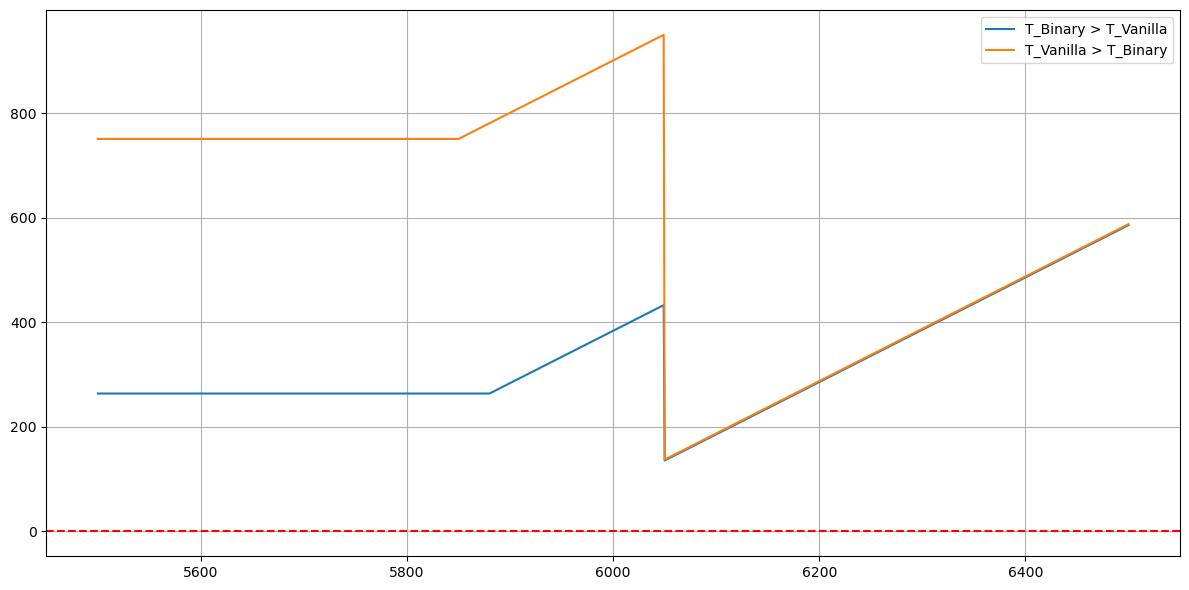

In [653]:
PnL_final = analyze_option_scenarios(5000, 6050, 0.20)

### It seems risk free but is it really?

# MC sim

In [657]:
def Monte_Carlo_PnL_Distribution(S_0, K_Binary, T_Binary, T_Vanilla, T_future, sigma, r=0.04, num_paths=1000, num_steps=252):
    # Initialize parameters
    init_params = Initialize(S_0=S_0, K_Binary=K_Binary, T_Binary=T_Binary, T_Vanilla=T_Vanilla, T_future=T_future, sigma=sigma, r=r)
    K_Vanilla = init_params['K_Vanilla']
    V_0 = init_params['V_0']
    B_0 = init_params['B_0']
    N = init_params['N']
    
    # Initial cost
    Cost = V_0 + N * B_0
    
    # Time grid - convert years to trading days
    trading_days_per_year = 252
    total_days = int(T_future * trading_days_per_year)
    
    # We need the price for each trading day
    days = np.arange(total_days + 1)  # 0 to total_days inclusive
    dt = 1/trading_days_per_year  # Time step of one trading day
    times = days / trading_days_per_year  # Convert days to years for calculations
    
    # Initialize array for stock price paths
    S = np.zeros((num_paths, total_days + 1))
    S[:, 0] = S_0
    
    # Also initialize array for PnL over time
    pnl_over_time = np.zeros((num_paths, total_days + 1))
    
    # Generate stock price paths using GBM
    for t in range(1, total_days + 1):
        Z = np.random.normal(0, 1, num_paths)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    # Store portfolio values after both options expire
    post_expiry_values = np.zeros(num_paths)
    latest_expiry = max(T_Vanilla, T_Binary)
    latest_expiry_idx = int(latest_expiry * trading_days_per_year)
    
    # Calculate PnL for each path at each time step
    for t in range(total_days + 1):
        current_time = times[t]
        for i in range(num_paths):
            # For the period before both options expire
            if current_time <= latest_expiry:
                # Calculate portfolio value normally
                portfolio_value = Portfolio_t(current_time, S[i, t], K_Vanilla, K_Binary, T_Binary, T_Vanilla, T_future, sigma, N, r)
                pnl_over_time[i, t] = portfolio_value - Cost
                
                # If we're at the latest expiry point, store the portfolio value for future use
                if t == latest_expiry_idx:
                    post_expiry_values[i] = portfolio_value
            else:
                # After both options expire, use the stored value from expiry
                pnl_over_time[i, t] = post_expiry_values[i] - Cost
    
    # Select a few sample paths for visualization
    sample_paths_indices = np.random.choice(num_paths, min(10, num_paths), replace=False)
    sample_paths = S[sample_paths_indices, :]
    sample_pnl_paths = pnl_over_time[sample_paths_indices, :]
    
    # Calculate statistics for the final PnL
    final_pnl = pnl_over_time[:, -1]
    
    # Calculate average PnL across all paths at each time step
    avg_pnl_over_time = np.mean(pnl_over_time, axis=0)
    
    # Calculate percentiles of PnL across all paths at each time step
    percentile_low_time = np.percentile(pnl_over_time, 2.5, axis=0)
    percentile_high_time = np.percentile(pnl_over_time, 97.5, axis=0)
    
    return {
        'final_pnl': final_pnl,
        'S_final': S[:, -1],
        'sample_paths': sample_paths,
        'sample_pnl_paths': sample_pnl_paths,
        'days': days,
        'pnl_over_time': pnl_over_time,
        'avg_pnl_over_time': avg_pnl_over_time,
        'percentile_low_time': percentile_low_time,
        'percentile_high_time': percentile_high_time,
        'statistics': {
            'mean_pnl': np.mean(final_pnl),
            'std_pnl': np.std(final_pnl),
            'median_pnl': np.median(final_pnl),
            'min_pnl': np.min(final_pnl),
            'max_pnl': np.max(final_pnl),
            'percentile_5': np.percentile(final_pnl, 5),
            'percentile_95': np.percentile(final_pnl, 95)
        }
    }

def plot_mc_results(mc_results, T_Vanilla, T_Binary, title="Monte Carlo Simulation Results"):
    # Plot 1: Sample Stock Price Paths
    plt.figure(figsize=(12,6))
    for i in range(mc_results['sample_paths'].shape[0]):
        plt.plot(mc_results['days'], mc_results['sample_paths'][i, :])
    
    # Mark option expiry days
    T_P_day = int(T_Vanilla * 252)
    T_C_day = int(T_Binary * 252)
    if T_P_day <= max(mc_results['days']):
        plt.axvline(x=T_P_day, color='g', linestyle='--', label=f'Binary Option Expiry (Day {T_P_day})')
    if T_C_day <= max(mc_results['days']):
        plt.axvline(x=T_C_day, color='r', linestyle='--', label=f'Vanilla Option Expiry (Day {T_C_day})')
    
    plt.title('Sample Stock Price Paths')
    plt.xlabel('Trading Days')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Sample PnL Paths over time
    plt.figure(figsize=(12,6))
    for i in range(mc_results['sample_pnl_paths'].shape[0]):
        plt.plot(mc_results['days'], mc_results['sample_pnl_paths'][i, :])
    
    # Add average PnL and confidence bands
    plt.plot(mc_results['days'], mc_results['avg_pnl_over_time'], 'k--', linewidth=2, label='Average PnL')
    plt.fill_between(mc_results['days'], 
                    mc_results['percentile_low_time'], 
                    mc_results['percentile_high_time'],
                    alpha=0.2, color='gray', label='90% Confidence Band')
    
    # Mark option expiry days
    if T_P_day <= max(mc_results['days']):
        plt.axvline(x=T_P_day, color='g', linestyle='--', label=f'Binary Option Expiry (Day {T_P_day})')
    if T_C_day <= max(mc_results['days']):
        plt.axvline(x=T_C_day, color='r', linestyle='--', label=f'Vanilla Option Expiry (Day {T_C_day})')
    
    plt.title('PnL Evolution Over Time')
    plt.xlabel('Trading Days')
    plt.ylabel('PnL')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 3: Final PnL Distribution
    plt.figure(figsize=(12,6))
    plt.hist(mc_results['final_pnl'], bins=int(len(mc_results['final_pnl'])/10), density=True, alpha=0.7)
    plt.axvline(mc_results['statistics']['mean_pnl'], color='r', linestyle='--', 
                label=f"Mean PnL: {mc_results['statistics']['mean_pnl']:.2f}")
    plt.axvline(mc_results['statistics']['median_pnl'], color='b', linestyle='--', 
                label=f"Median PnL: {mc_results['statistics']['median_pnl']:.2f}")
    plt.axvline(mc_results['statistics']['percentile_5'], color='g', linestyle='--', 
                label=f"5th Percentile: {mc_results['statistics']['percentile_5']:.2f}")
    plt.axvline(mc_results['statistics']['percentile_95'], color='g', linestyle='--', 
                label=f"95th Percentile: {mc_results['statistics']['percentile_95']:.2f}")
    
    plt.title('Final PnL Distribution')
    plt.xlabel('PnL')
    plt.ylabel('Density')
    plt.legend()
    
    # Set reasonable x-limits for the histogram
    lower_bound = max(mc_results['statistics']['percentile_5'] * 2, mc_results['final_pnl'].min())
    upper_bound = min(mc_results['statistics']['percentile_95'] * 2, mc_results['final_pnl'].max())
    plt.xlim(lower_bound, upper_bound)
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [686]:
S_0 = 6000
K_Binary = 6050
T_Vanilla = 20/252
T_Binary = 22/252
T_future = 40/252
sigma = 0.30
r = 0.04
 
mc_results = Monte_Carlo_PnL_Distribution(S_0, K_Binary, T_Binary, T_Vanilla, T_future, sigma, r)

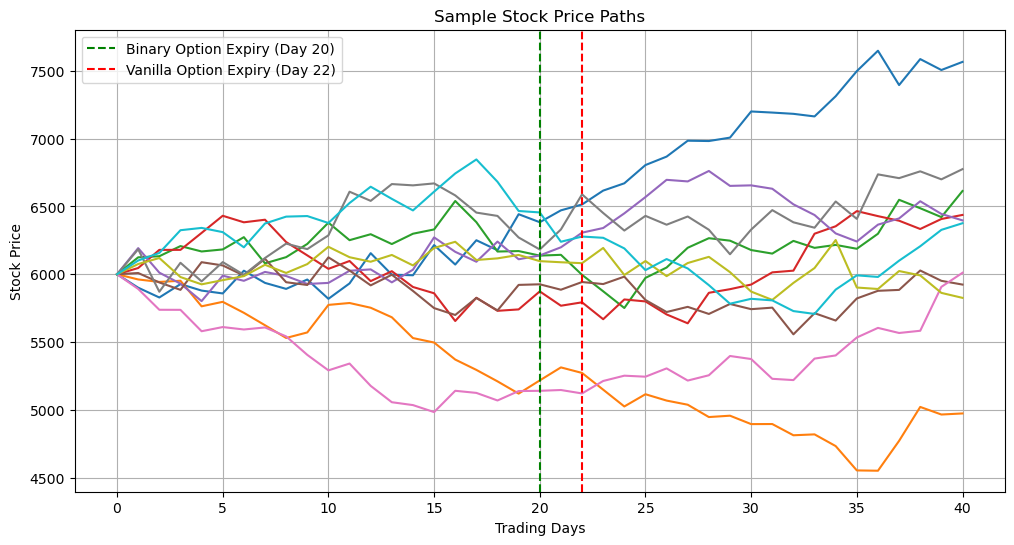

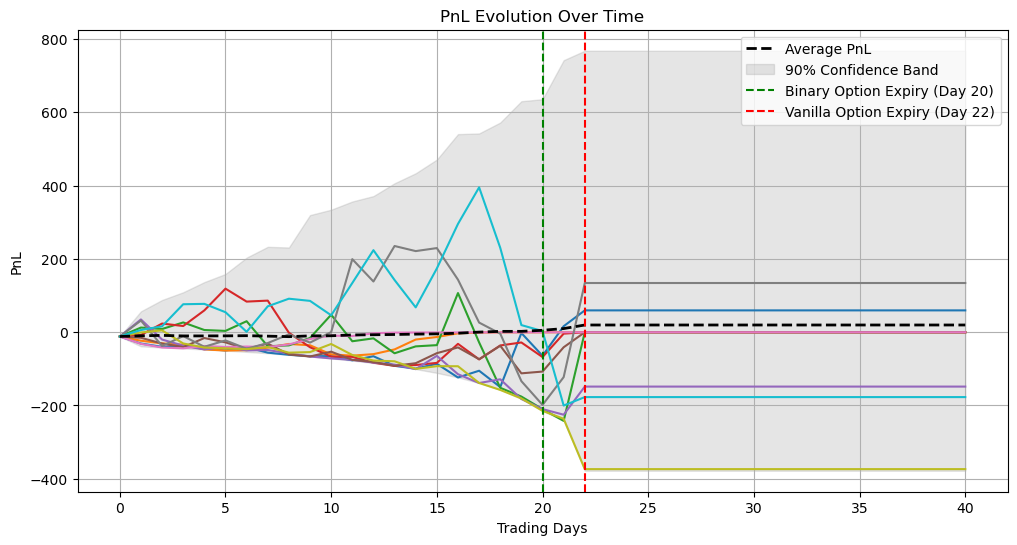

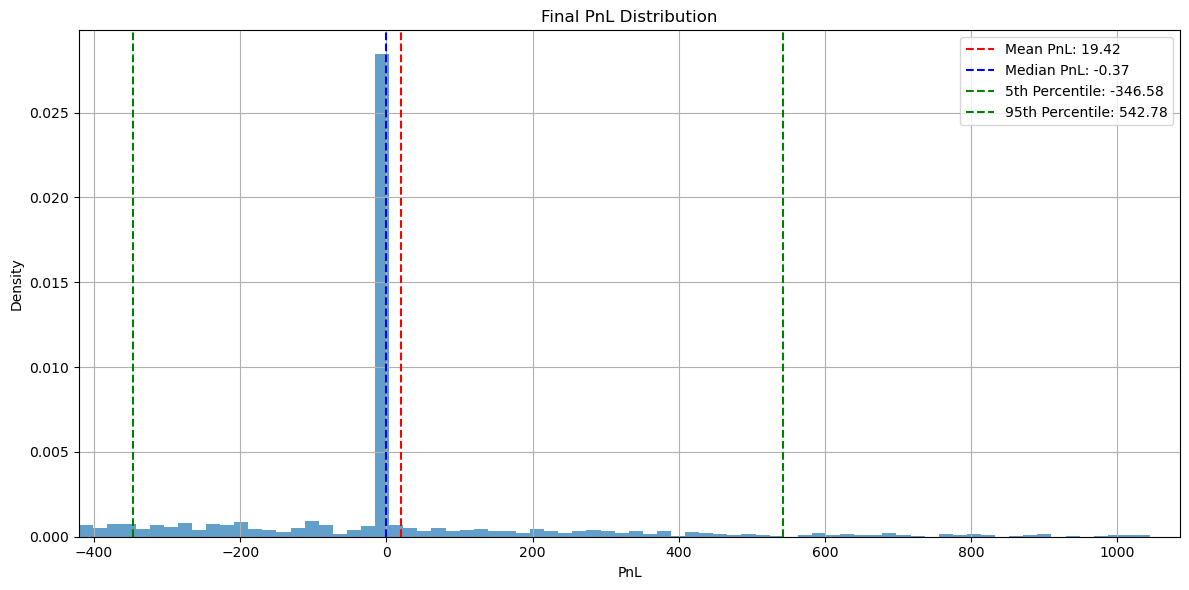

Max loss: -420.36700475974385
Max win: 1507.322164221298


In [687]:
plot_mc_results(mc_results, T_Vanilla, T_Binary)

print(f"Max loss: {mc_results['final_pnl'].min()}")
print(f"Max win: {mc_results['final_pnl'].max()}")

# This is far from risk free!

In [689]:
def analyze_pnl_distribution(mc_results, T_Binary, T_Vanilla, T_future):
    # Extract data from mc_results
    pnl_over_time = mc_results['pnl_over_time']
    days = mc_results['days']
    trading_days_per_year = 252
    
    # Key dates in day indices
    binary_expiry_idx = int(T_Binary * trading_days_per_year)
    vanilla_expiry_idx = int(T_Vanilla * trading_days_per_year)
    
    # Calculate metrics over time
    metrics_over_time = {
        'mean': np.mean(pnl_over_time, axis=0),
        'median': np.median(pnl_over_time, axis=0),
        'std': np.std(pnl_over_time, axis=0),
        'skewness': stats.skew(pnl_over_time, axis=0),
        'var_95': -np.percentile(pnl_over_time, 5, axis=0),  # 95% VaR
        'cvar_95': -np.mean(np.where(pnl_over_time <= np.percentile(pnl_over_time, 5, axis=0, keepdims=True), 
                                     pnl_over_time, np.nan), axis=0),  # 95% CVaR
        'positive_prob': np.mean(pnl_over_time > 0, axis=0)  # Probability of positive PnL
    }
    
    return {
        'metrics_over_time': metrics_over_time,
        'days': days,
        'binary_expiry_day': binary_expiry_idx,
        'vanilla_expiry_day': vanilla_expiry_idx
    }

def visualize_pnl_analysis(mc_results, analysis_results, title="PnL Distribution Analysis"):
    days = mc_results['days']
    binary_expiry_day = analysis_results['binary_expiry_day']
    vanilla_expiry_day = analysis_results['vanilla_expiry_day']
    
    # Create figure with three subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    fig.suptitle(title, fontsize=16)
    
    # Plot 1: PnL evolution (mean, std, skewness)
    ax = axes[0]
    ax.plot(days, analysis_results['metrics_over_time']['mean'], 'r-', label='Mean PnL')
    ax.plot(days, analysis_results['metrics_over_time']['median'], 'b-', label='Median PnL')
    ax.fill_between(days, 
                    analysis_results['metrics_over_time']['mean'] - 3*analysis_results['metrics_over_time']['std'], 
                    analysis_results['metrics_over_time']['mean'] + 3*analysis_results['metrics_over_time']['std'],
                    alpha=0.2, color='blue', label='3 Std Dev')
    ax2 = ax.twinx()
    ax2.plot(days, analysis_results['metrics_over_time']['skewness'],color = 'purple', linestyle = '--', label='Skewness')
    
    # Add vertical lines for option expiries
    ax.axvline(x=binary_expiry_day, color='g', linestyle=':', label='Binary Expiry')
    ax.axvline(x=vanilla_expiry_day, color='r', linestyle=':', label='Vanilla Expiry')
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    # Add legends and labels
    ax.set_title('PnL Evolution')
    ax.set_xlabel('Trading Days')
    ax.set_ylabel('PnL')
    ax.legend(loc='upper left')
    ax2.set_ylabel('Skewness')
    ax2.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Risk metrics evolution
    ax = axes[1]
    ax.plot(days, analysis_results['metrics_over_time']['var_95'], 'r-', label='95% VaR')
    ax.plot(days, analysis_results['metrics_over_time']['cvar_95'], 'm--', label='95% CVaR')
    ax.plot(days, analysis_results['metrics_over_time']['std'], 'g-.', label='Std Deviation')
    
    # Add vertical lines for option expiries
    ax.axvline(x=binary_expiry_day, color='g', linestyle=':', label='Binary Expiry')
    ax.axvline(x=vanilla_expiry_day, color='r', linestyle=':', label='Vanilla Expiry')
    
    # Add labels and legend
    ax.set_title('Risk Metrics Evolution')
    ax.set_xlabel('Trading Days')
    ax.set_ylabel('Risk Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Probability of positive PnL
    ax = axes[2]
    ax.plot(days, analysis_results['metrics_over_time']['positive_prob'] * 100, 'b-')
    
    # Add vertical lines for option expiries
    ax.axvline(x=binary_expiry_day, color='g', linestyle=':', label='Binary Expiry')
    ax.axvline(x=vanilla_expiry_day, color='r', linestyle=':', label='Vanilla Expiry')
    ax.axhline(y=50, color='k', linestyle='--', alpha=0.3)
    
    # Add labels
    ax.set_title('Probability of Positive PnL (%)')
    ax.set_xlabel('Trading Days')
    ax.set_ylabel('Probability (%)')
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

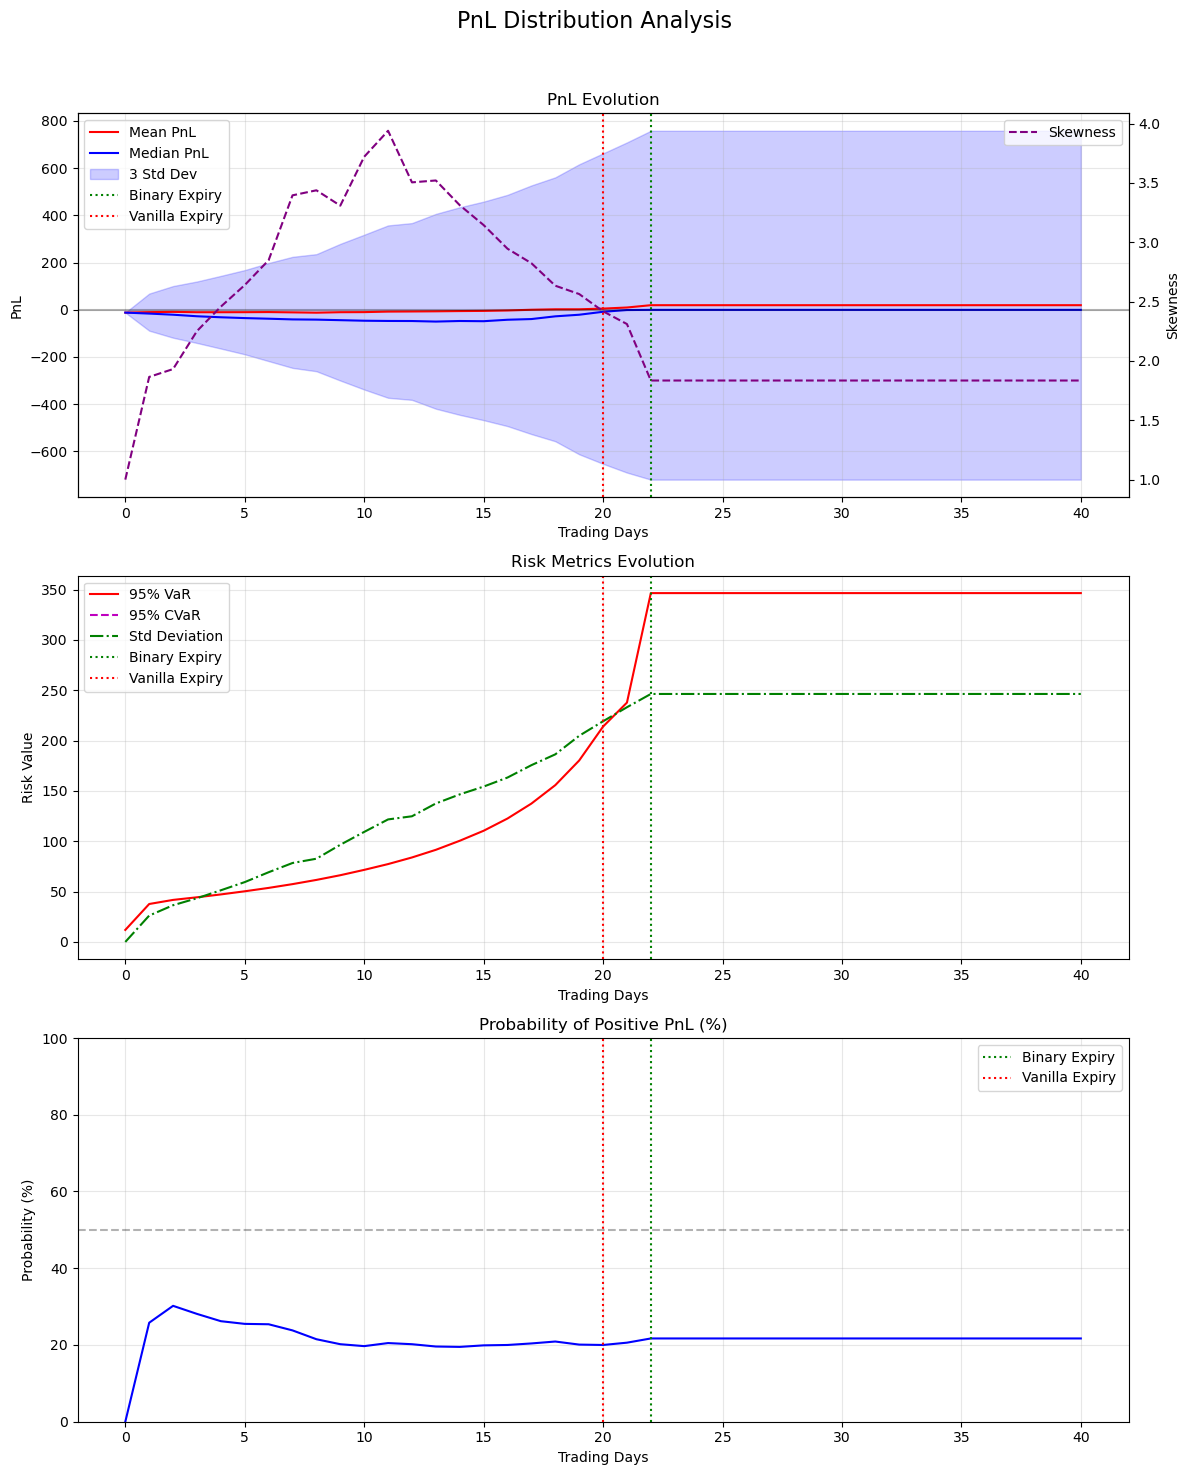

In [690]:
analysis_results = analyze_pnl_distribution(mc_results, T_Binary, T_Vanilla, T_future)

visualize_pnl_analysis(mc_results, analysis_results)